In [10]:
import adddeps
import h5py
from matplotlib import pyplot as plt
import matplotlib
import numpy as np
from scipy.stats import norm,normaltest, probplot

import pandas as pd
import sqlalchemy
from collections import defaultdict
import datetime
import importlib
from simulator.magnetic import SimulatorMagnetic
from simulator.models import Client, SimulationAlchemy as Simulation
from tqdm import tqdm

import multiprocessing
from multiprocessing import Pool, cpu_count

from relaxation.estimators import relaxation_finder_collision
import logging
import sys, os
from settings import DFS_PATH
from utils.utils import plot_mean_std, delete_dfs, smoothen, concat
from utils.ACfunctions import Cv, Cr


from scipy import integrate
import scipy.optimize

matplotlib.rcParams["figure.dpi"] = 150
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
client = Client()

In [8]:
def group_items_by_L(items):
    groups = defaultdict(list)
    for item in items:
        groups[round(item.L_init,2)].append(item)
    return groups

items = client.get_simulation_groups(["GE 1.0"] )

items = group_items_by_L(items)

In [12]:
items = client.get_simulation_groups(["GE 1.0"] )

for item in tqdm(items):
    hdf_file = "/data/biophys/ashmat/LJ-magnetic/subresults/ac3.{}.hdf5".format(item.hash)
    with h5py.File(hdf_file) as ds:
        item.history["ac"] = ds["ac"][:]
        item.history["ac_relative"] = ds["ac_relative"][:]
        
        item.history["Omega"] = ds.attrs["O"]
        
        item.history["Temp"] = ds.attrs["T"]

  0%|          | 0/200 [00:00<?, ?it/s]


FileNotFoundError: [Errno 2] Unable to open file (unable to open file: name = '/data/biophys/ashmat/LJ-magnetic/subresults/ac3.1952da01e795b701.hdf5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [11]:
dt = item.record_interval

In [14]:
df = pd.DataFrame(
{
    "L_init":[round(item.L_init,3) for item in items],
    "E_init":[round(item.E_init,3) for item in items],
    "Omega": [round(item.history["Omega"],5) for item in items],
    "Temp":  [round(item.history["Temp"], 5) for item in items],
    "integral": [dt*integrate.simpson(item.history["ac"]) for item in items],
    "integral_relative": [dt*integrate.simpson(item.history["ac_relative"]) for item in items],
}
)

In [31]:
gb = df.groupby([ "L_init"])
dfg = gb.apply(lambda gp:gp.mean())
dfg["std"] = gb.apply(lambda gp:np.imag(gp.integral_relative).std())

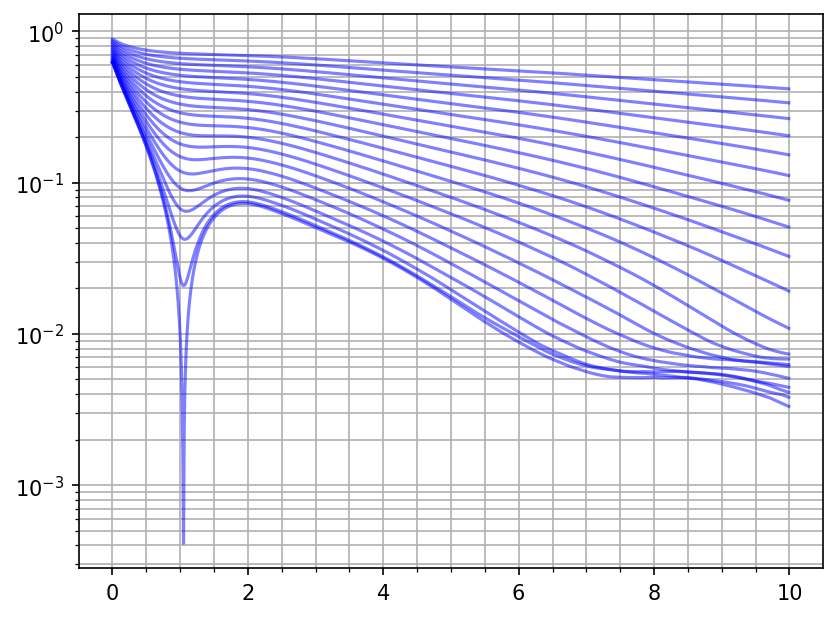

In [28]:
for gp_name, ids in gb.groups.items():
    data = np.stack([items[i].history["ac_relative"] for i in ids])

    O = np.mean([items[i].history["Omega"] for i in ids])
    T = np.mean([items[i].history["Temp"] for i in ids])

    data = (data)[:,:1000]

    mean = np.mean(data, axis=0)
    if not ((0.069 > np.abs(mean[40]) > 0.068)):
#         continue
        pass
#     print(gp_name)
    ts = np.arange(len(mean))*dt

    plt.plot(ts, np.abs(mean), color="blue", alpha=0.5)


plt.yscale("log")
plt.minorticks_on()
plt.grid(which="both")

In [ ]:
ids = gb.groups[(771.808, 431.139)]
i=0

data = np.stack([items[i].history["ac"] for i in ids])

O = np.mean([items[i].history["Omega"] for i in ids])
T = np.mean([items[i].history["Temp"] for i in ids])

data = np.real(data)[:,:1000]

mean = np.mean(data, axis=0)
std = np.std(data, axis=0)/np.sqrt(len(data))
ts = np.arange(len(mean))*dt
plot_mean_std(ts, mean, std, color=i);i+=1

plt.plot(ts, np.real(Cv(ts, gamma=0.75, T =T, O=O )), color="orange", ls="--")

plt.plot()
plt.grid()


In [23]:
def get_gamma(gp_name, W):
    ids = gb.groups[gp_name]
    
    data = np.stack([items[i].history["ac_relative"] for i in ids])

    O = np.mean([items[i].history["Omega"] for i in ids])
    T = np.mean([items[i].history["Temp"] for i in ids])

    data = (data)[:,:W]

    mean = np.mean(data, axis=0)
    std = np.std(data, axis=0)/np.sqrt(len(data))
    ts = np.arange(len(mean))*dt
    
    def f(gamma, W):
        if gamma < 0.0001:
            return np.inf

    #     W = 200
        c = Cr(ts[:W], gamma, T, O)
        c1 = mean[:W]
        d = c-c1
        return np.real(d.dot(d.conj())) / len(d)
    
    optres = scipy.optimize.minimize(f, 1, args=(W,))
    return {"crit": optres.fun, "gamma": optres.x[0]}
    

In [41]:
dfg = dfg.drop(["crit", "gamma"], axis=1, errors='ignore')

dfg = dfg.join(pd.DataFrame([get_gamma(gp_name, 1000) for gp_name in dfg.index], index=dfg.index))

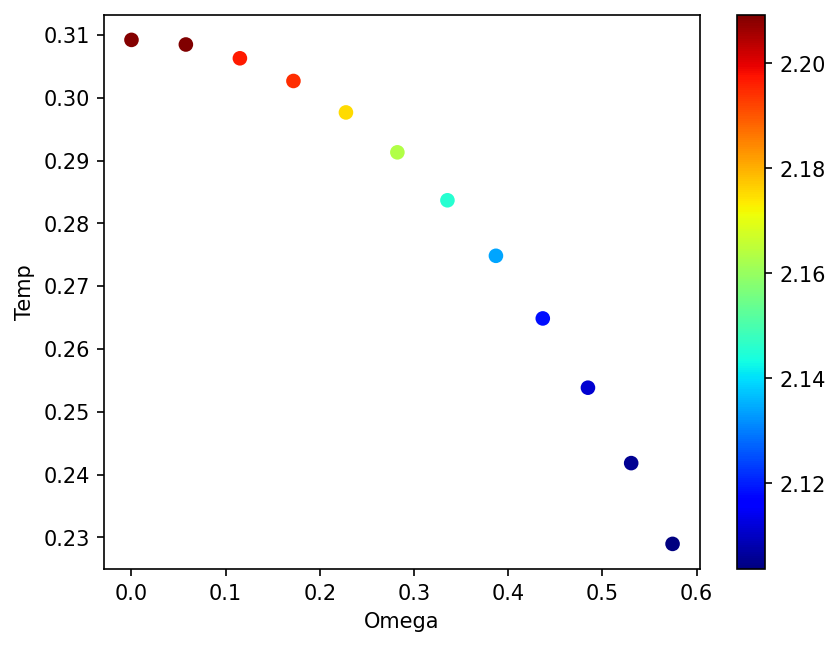

In [43]:
dfg = dfg[dfg.Omega<0.6]
plt.scatter(dfg.Omega, dfg.Temp, c=dfg.gamma,cmap="jet")
plt.xlabel("Omega")
plt.ylabel("Temp")
# plt.scatter(dfg.Omega, dfg.Temp, c=dfg["std"]/np.imag(dfg["integral_relative"]))
plt.colorbar()